#### Importing Required Libraries

In [242]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from datetime import datetime
from numpy import asarray
from sklearn.utils import shuffle
# import tensorflow as tf
# import pickle
# import csv
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

## 1.Recession

#### Reading Recession Data from CSV file and Defining the Recession Years

In [243]:
df1 = pd.read_csv("../testing data/Reccession_Dataset.csv")
df1.head()
df1.tail()
# Handling missing values
df1 = df1.dropna()
df1.info()
df1.describe()
df1["Year "] = pd.to_datetime(df1["Year "], format="%Y")
df1.set_index("Year ", inplace=True)
# Define recession periods
recession_periods = [
    (pd.to_datetime("1980"), pd.to_datetime("1981")),
    (pd.to_datetime("1990"), pd.to_datetime("1991")),
    (pd.to_datetime("2008"), pd.to_datetime("2009")),
    (pd.to_datetime("2020"), pd.to_datetime("2021")),
]

# Create masks for recession and pre and post-recession periods
recession_mask = np.zeros(len(df1), dtype=bool)
for start, end in recession_periods:
    recession_mask |= (df1.index >= start) & (df1.index <= end)

# Create pre-recession and post-recession periods
pre_recession = df1[~recession_mask]
recession = df1[recession_mask]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Year                           43 non-null     int64  
 1   Consumer Spending (Recession)  43 non-null     float64
 2   GDP Growth                     43 non-null     float64
 3   Debt                           43 non-null     float64
 4   Employment Rate                43 non-null     float64
 5   Interest Rate                  43 non-null     float64
 6   Government Expenditure         43 non-null     object 
 7   Money Stock                    43 non-null     int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 2.8+ KB


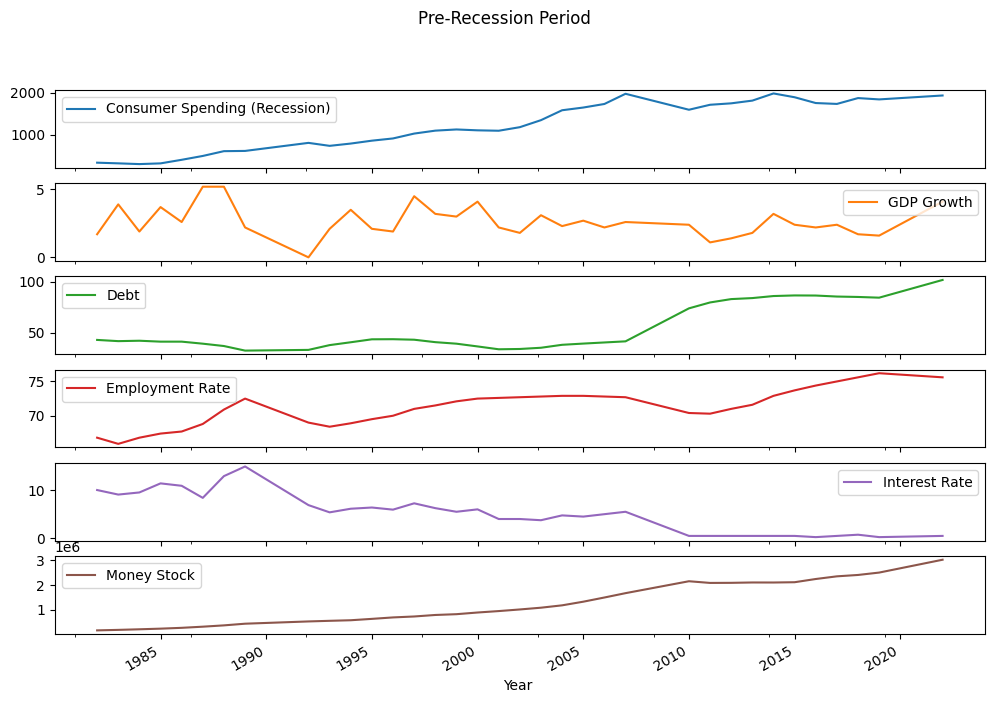

In [244]:
# Visualize each period
pre_recession.plot(subplots=True, figsize=(12, 8), title="Pre-Recession Period")
plt.show()

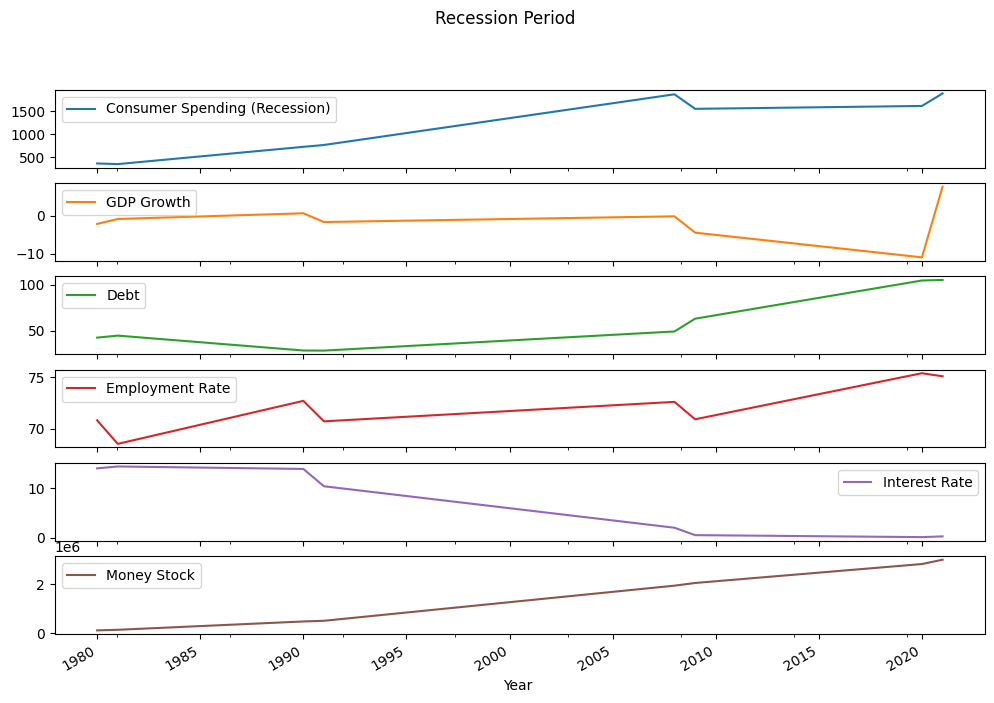

In [245]:
# Recession Period
recession.plot(subplots=True, figsize=(12, 8), title="Recession Period")
plt.show()

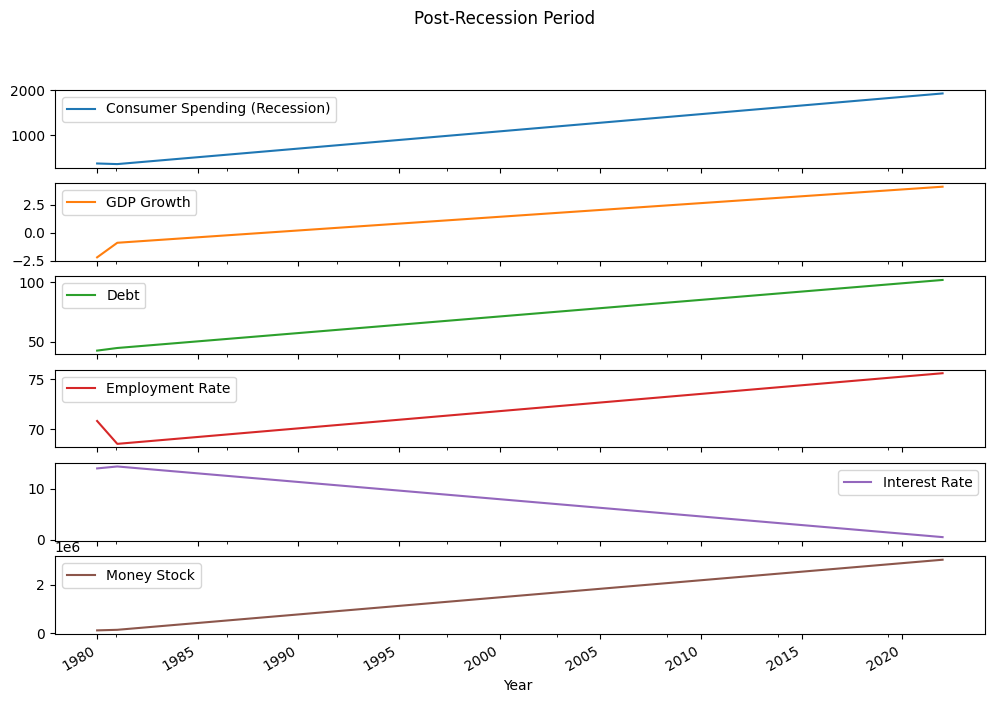

In [246]:
# Distribute remaining years in post-recession
post_recession = df1[
    (df1.index < pre_recession.index.min()) | (df1.index > recession.index.max())
]
post_recession.plot(subplots=True, figsize=(12, 8), title="Post-Recession Period")
plt.show()

#### LSTM model to predict the Recession

In [247]:
# Selected target variable (Consumer Spending during recession)
target_variable = "Consumer Spending (Recession)"

# Extraction of the target variable
y = df1[target_variable].values

# Normalize the data
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y.reshape(-1, 1))

# Define the sequence length
sequence_length = 10

# Creation of sequences for the LSTM model
sequences = []
for i in range(len(y_scaled) - sequence_length):
    sequences.append(y_scaled[i : i + sequence_length])

# Conversion to numpy array
sequences = np.array(sequences)

# Spliting the data into features (X) and target variable (y)
X = sequences[:, :-1]
y = sequences[:, -1]

# Splitting the data into training and testing sets (80% and 20% Splitting)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Build and train of the LSTM Model
model = Sequential()
model.add(LSTM(50, activation="relu", input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Early stopping to prevent overfitting
from keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

# Train the model
model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
)

# Model summary
model.summary()

# Evaluate the model on the test set
loss, mae = model.evaluate(X_test, y_test)

# Print Mean Absolute Error (MAE)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Inverse transform the scaled data for visualization
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Accuracy of the LSTM Model
accuracy = 1 - mae / np.mean(y_test_inv)
print(f"Accuracy: {accuracy:.2%}")

Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 0.5587 - mae: 0.6776 - val_loss: 0.5216 - val_mae: 0.7021
Epoch 2/50
1/1 [==============================] - 0s 92ms/step - loss: 0.5415 - mae: 0.6665 - val_loss: 0.5053 - val_mae: 0.6911
Epoch 3/50
1/1 [==============================] - 0s 79ms/step - loss: 0.5252 - mae: 0.6558 - val_loss: 0.4896 - val_mae: 0.6802
Epoch 4/50
1/1 [==============================] - 0s 111ms/step - loss: 0.5096 - mae: 0.6453 - val_loss: 0.4743 - val_mae: 0.6695
Epoch 5/50
1/1 [==============================] - 0s 90ms/step - loss: 0.4943 - mae: 0.6350 - val_loss: 0.4592 - val_mae: 0.6587
Epoch 6/50
1/1 [==============================] - 0s 76ms/step - loss: 0.4792 - mae: 0.6246 - val_loss: 0.4444 - val_mae: 0.6481
Epoch 7/50
1/1 [==============================] - 0s 102ms/step - loss: 0.4644 - mae: 0.6142 - val_loss: 0.4299 - val_mae: 0.6374
Epoch 8/50
1/1 [==============================] - 0s 90ms/step - loss: 0.4498 - mae: 0.6037 - val

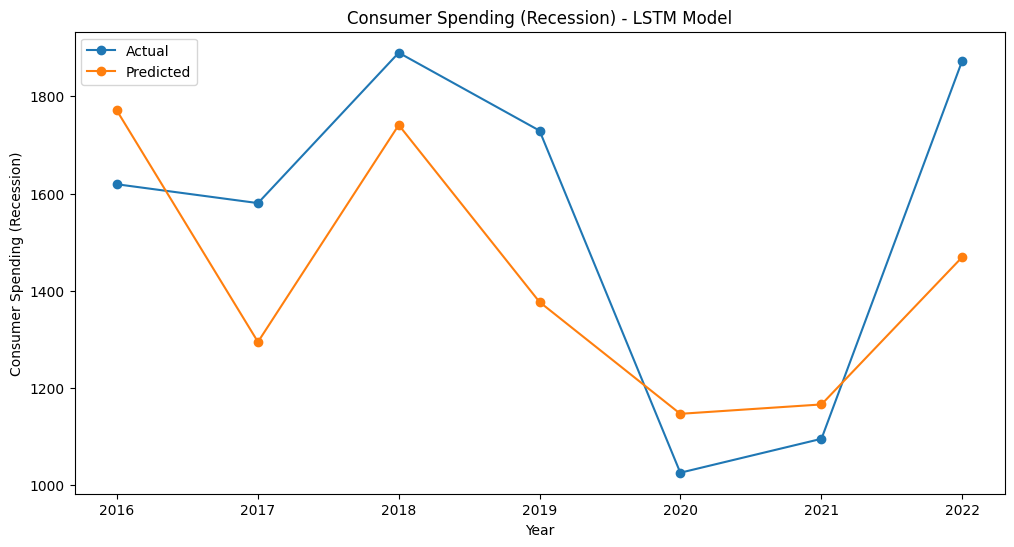

In [248]:
# Plot the trend line with data values
plt.figure(figsize=(12, 6))
plt.plot(df1.index[-len(y_test_inv) :], y_test_inv, label="Actual", marker="o")
plt.plot(df1.index[-len(y_pred_inv) :], y_pred_inv, label="Predicted", marker="o")
plt.title("Consumer Spending (Recession) - LSTM Model")
plt.xlabel("Year")
plt.ylabel("Consumer Spending (Recession)")
plt.legend()
plt.show()

#### Future Recession Prediction

In [249]:
# Use the last sequence from the dataset
last_sequence = X[-1]

# Reshape to match the model input shape
last_sequence = last_sequence.reshape(1, last_sequence.shape[0], 1)

# Predict the future values
number_of_future_steps = 5  # Adjust this according to your needs
future_values = []
for _ in range(number_of_future_steps):
    prediction = model.predict(last_sequence)
    future_values.append(prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = prediction[0, 0]

# Inverse transform the predicted values
future_values_inv = scaler.inverse_transform(np.array(future_values).reshape(-1, 1))

# Print the predicted future values
print("Predicted Future Values:")
print(future_values_inv)

1/1 [==============================] - 0s 52ms/step
Predicted Future Values:
[[1769.3093]
 [1774.2642]
 [1768.2914]
 [1747.47  ]
 [1736.0251]]


In [257]:
X

array([[[0.03797687],
        [0.02981813],
        [0.0199919 ],
        [0.01057064],
        [0.        ],
        [0.01014781],
        [0.06077371],
        [0.11524673],
        [0.1830179 ]],

       [[0.02981813],
        [0.0199919 ],
        [0.01057064],
        [0.        ],
        [0.01014781],
        [0.06077371],
        [0.11524673],
        [0.1830179 ],
        [0.18636477]],

       [[0.0199919 ],
        [0.01057064],
        [0.        ],
        [0.01014781],
        [0.06077371],
        [0.11524673],
        [0.1830179 ],
        [0.18636477],
        [0.25404662]],

       [[0.01057064],
        [0.        ],
        [0.01014781],
        [0.06077371],
        [0.11524673],
        [0.1830179 ],
        [0.18636477],
        [0.25404662],
        [0.27803452]],

       [[0.        ],
        [0.01014781],
        [0.06077371],
        [0.11524673],
        [0.1830179 ],
        [0.18636477],
        [0.25404662],
        [0.27803452],
        [0.30030134]],



In [219]:
recession_future_pred_list = np.insert(future_values_inv, 0, y_test_inv[-1])
recession_future_pred_list

array([1873.23  , 1885.3505, 1900.4994, 1908.5763, 1901.1754, 1903.8601],
      dtype=float32)

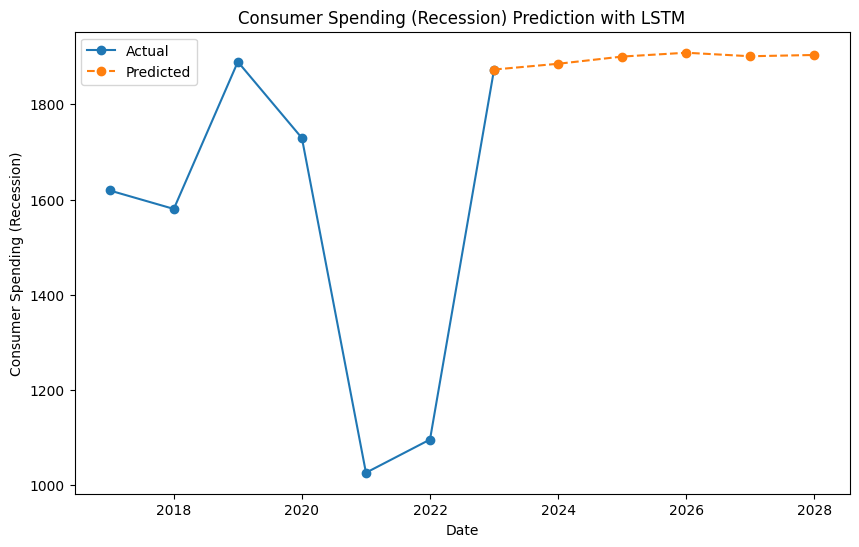

In [255]:
# Plotting
plt.figure(figsize=(10, 6))

# If not, convert 'Year' to datetime index before proceeding
idf.index = pd.to_datetime(idf.index, format='%Y')
# Generate existing years
existing_years = pd.date_range(start=idf.index[-len(y_test_inv)] + pd.DateOffset(years=1), periods=len(y_test_inv), freq='Y').year

# Plot the original data
plt.plot(existing_years, y_test_inv, label="Actual", marker='o')

# Plot the predicted values on the existing plot
# Generate additional years
future_years = pd.date_range(start=idf.index[-1] + pd.DateOffset(years=1), periods=6, freq='Y').year
plt.plot(future_years, recession_future_pred_list, '--', label="Predicted", marker='o')

plt.title("Consumer Spending (Recession) Prediction with LSTM")
plt.xlabel("Date")
plt.ylabel("Consumer Spending (Recession)")
plt.legend()
plt.show()

## 2. Inflation

#### Reading Inflation data from excel

In [221]:
# pip install xlrd
df2 = pd.read_excel("../testing data/Inflation_Dataset.xlsx")
df2.head()
df2.tail()
df2.info()
df2.describe()
df2.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Year                    43 non-null     int64  
 1   Inflation               43 non-null     float64
 2   GDP Growth              43 non-null     float64
 3   Debt                    43 non-null     float64
 4   Employment Rate         43 non-null     float64
 5   Interest Rate           43 non-null     float64
 6   Government Expenditure  43 non-null     float64
 7   Money Stock             43 non-null     int64  
dtypes: float64(6), int64(2)
memory usage: 2.8 KB


Year                      0
Inflation                 0
GDP Growth                0
Debt                      0
Employment Rate           0
Interest Rate             0
Government Expenditure    0
Money Stock               0
dtype: int64

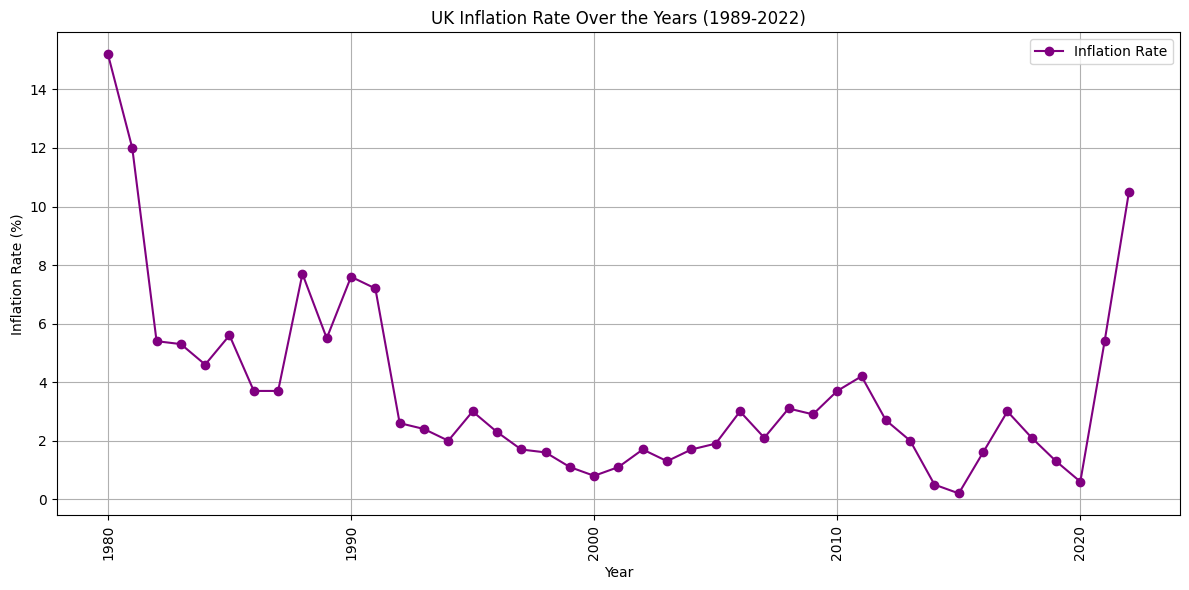

In [222]:
# Creating the plot
plt.figure(figsize=(12, 6))
plt.plot(
    df2["Year "],
    df2["Inflation "],
    marker="o",
    linestyle="-",
    color="purple",
    label="Inflation Rate",
)
# Customize the plot
plt.title("UK Inflation Rate Over the Years (1989-2022)")
plt.xlabel("Year")
plt.ylabel("Inflation Rate (%)")
plt.grid(True)
plt.legend()
# Rotating the x-axis labels for better readability
plt.xticks(rotation=90)
# Showing the plot
plt.tight_layout()
plt.show()

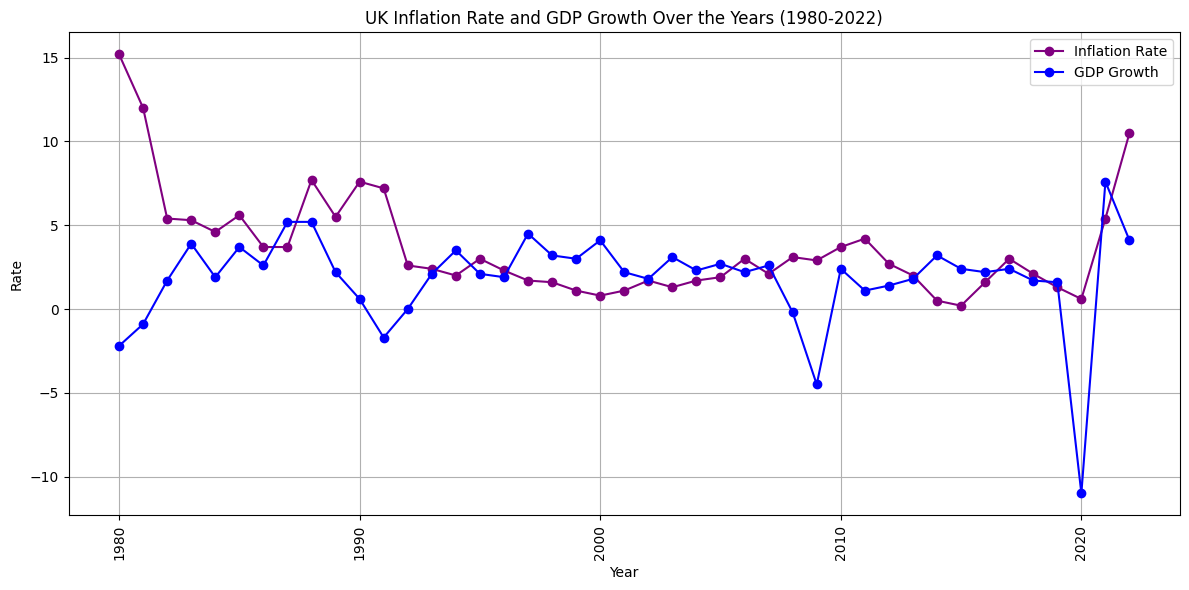

In [223]:
# Creating the plot
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(
    df2["Year "],
    df2["Inflation "],
    marker="o",
    linestyle="-",
    color="purple",
    label="Inflation Rate",
)
plt.plot(
    df2["Year "],
    df2["GDP Growth"],
    marker="o",
    linestyle="-",
    color="blue",
    label="GDP Growth",
)

# Customize the plot
plt.title("UK Inflation Rate and GDP Growth Over the Years (1980-2022)")
plt.xlabel("Year")
plt.ylabel("Rate")
plt.grid(True)
plt.legend()

# Rotating the x-axis labels for better readability
plt.xticks(rotation=90)

# Showing the plot
plt.tight_layout()
plt.show()

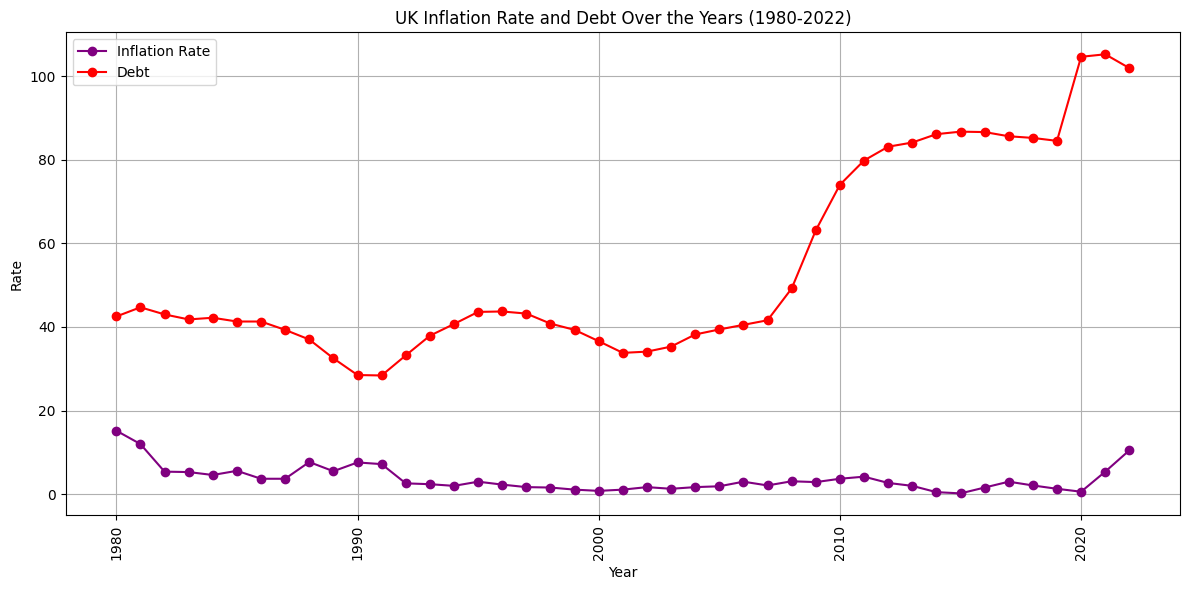

In [224]:
# Creating the plot
plt.figure(figsize=(12, 6))
plt.plot(
    df2["Year "],
    df2["Inflation "],
    marker="o",
    linestyle="-",
    color="purple",
    label="Inflation Rate",
)
plt.plot(
    df2["Year "], df2["Debt"], marker="o", linestyle="-", color="red", label="Debt"
)

# Customize the plot
plt.title("UK Inflation Rate and Debt Over the Years (1980-2022)")
plt.xlabel("Year")
plt.ylabel("Rate")
plt.grid(True)
plt.legend()

# Rotating the x-axis labels for better readability
plt.xticks(rotation=90)

# Showing the plot
plt.tight_layout()
plt.show()

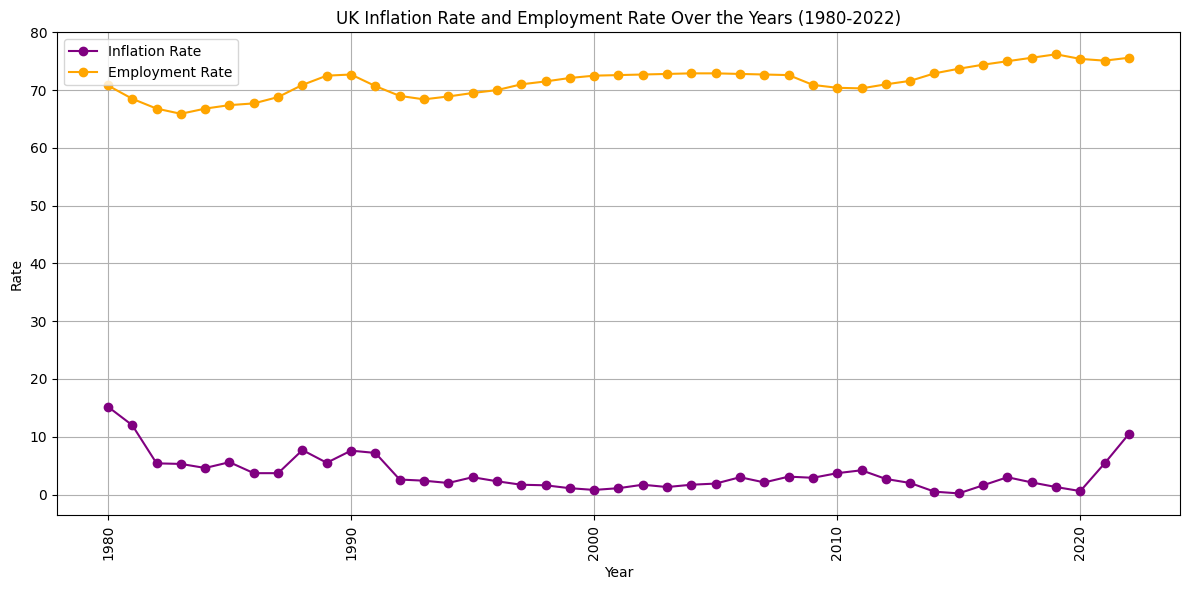

In [225]:
# Creating the plot
plt.figure(figsize=(12, 6))
plt.plot(
    df2["Year "],
    df2["Inflation "],
    marker="o",
    linestyle="-",
    color="purple",
    label="Inflation Rate",
)
plt.plot(
    df2["Year "],
    df2["Employment Rate"],
    marker="o",
    linestyle="-",
    color="orange",
    label="Employment Rate",
)

# Customize the plot
plt.title("UK Inflation Rate and Employment Rate Over the Years (1980-2022)")
plt.xlabel("Year")
plt.ylabel("Rate")
plt.grid(True)
plt.legend()

# Rotating the x-axis labels for better readability
plt.xticks(rotation=90)

# Showing the plot
plt.tight_layout()
plt.show()

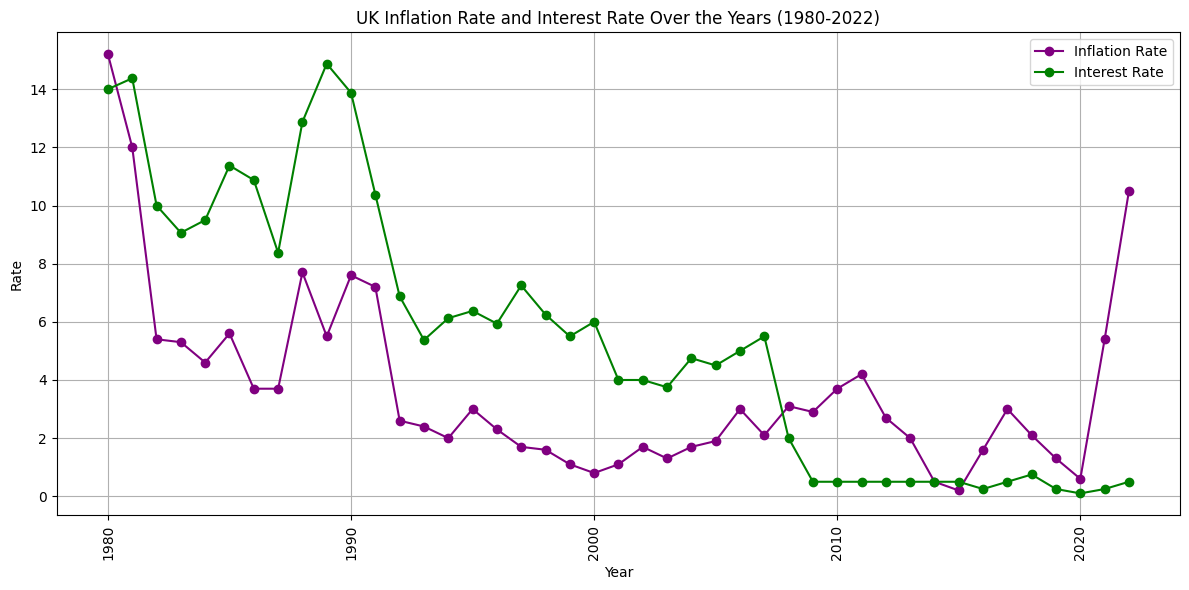

In [226]:
# Creating the plot
plt.figure(figsize=(12, 6))
plt.plot(
    df2["Year "],
    df2["Inflation "],
    marker="o",
    linestyle="-",
    color="purple",
    label="Inflation Rate",
)
plt.plot(
    df2["Year "],
    df2["Interest Rate"],
    marker="o",
    linestyle="-",
    color="green",
    label="Interest Rate",
)

# Customize the plot
plt.title("UK Inflation Rate and Interest Rate Over the Years (1980-2022)")
plt.xlabel("Year")
plt.ylabel("Rate")
plt.grid(True)
plt.legend()

# Rotating the x-axis labels for better readability
plt.xticks(rotation=90)

# Showing the plot
plt.tight_layout()
plt.show()

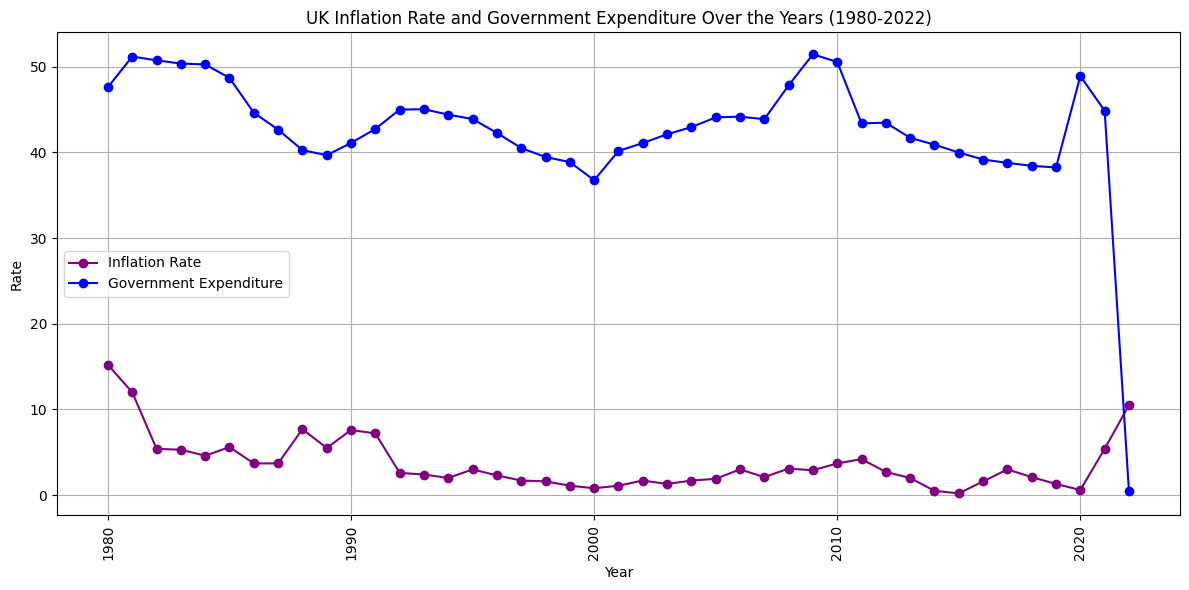

In [227]:
# Creating the plot
plt.figure(figsize=(12, 6))
plt.plot(
    df2["Year "],
    df2["Inflation "],
    marker="o",
    linestyle="-",
    color="purple",
    label="Inflation Rate",
)
plt.plot(
    df2["Year "],
    df2["Government Expenditure"],
    marker="o",
    linestyle="-",
    color="blue",
    label="Government Expenditure",
)

# Customize the plot
plt.title("UK Inflation Rate and Government Expenditure Over the Years (1980-2022)")
plt.xlabel("Year")
plt.ylabel("Rate")
plt.grid(True)
plt.legend()

# Rotating the x-axis labels for better readability
plt.xticks(rotation=90)

# Showing the plot
plt.tight_layout()
plt.show()

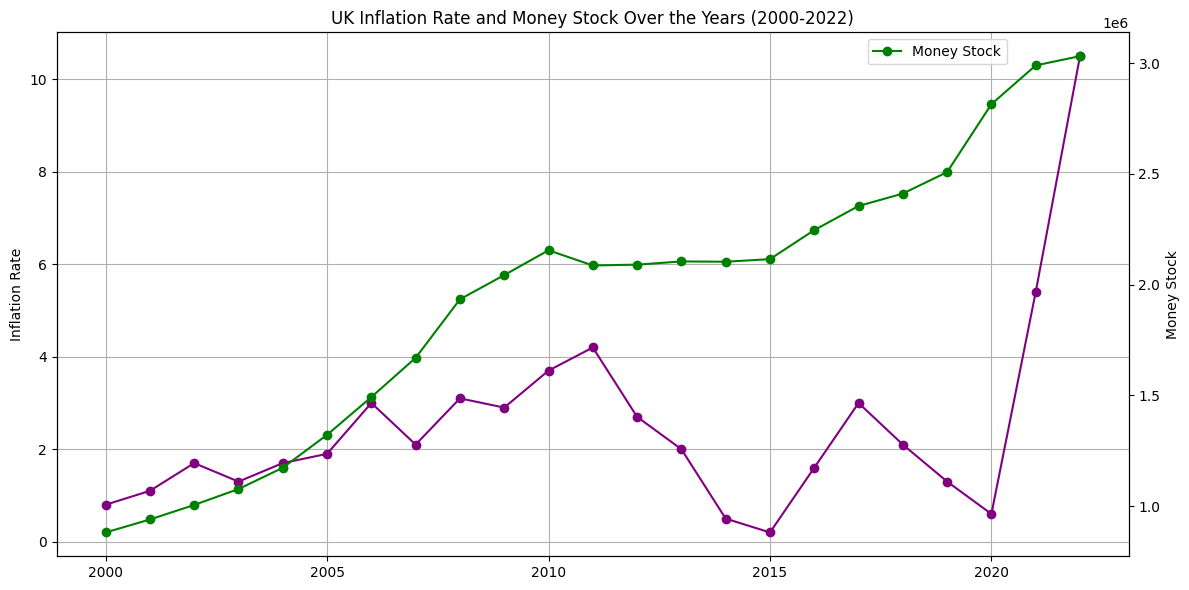

In [228]:
# Creating the plot
plt.figure(figsize=(12, 6))

# Filter the data to include only the range of years you're interested in (e.g., from 2000 to 2022)
start_year = 2000
end_year = 2022
filtered_df = df2[(df2["Year "] >= start_year) & (df2["Year "] <= end_year)]

# Plot Inflation Rate on the primary y-axis (left)
plt.plot(
    filtered_df["Year "],
    filtered_df["Inflation "],
    marker="o",
    linestyle="-",
    color="purple",
    label="Inflation Rate",
)
plt.ylabel("Inflation Rate")
plt.grid(True)

# Create a secondary y-axis (right) for Money Stock
ax2 = plt.twinx()
ax2.plot(
    filtered_df["Year "],
    filtered_df["Money Stock"],
    marker="o",
    linestyle="-",
    color="green",
    label="Money Stock",
)
ax2.set_ylabel("Money Stock")

# Set labels and title
plt.title(f"UK Inflation Rate and Money Stock Over the Years ({start_year}-{end_year})")
plt.xlabel("Year")

# Display the legend
plt.legend(loc="upper left", bbox_to_anchor=(0.75, 1))

# Rotating the x-axis labels for better readability
plt.xticks(rotation=90)

# Showing the plot
plt.tight_layout()
plt.show()

#### LSTM Model to predict the inflation

In [229]:
# Selected target variable (Inflation)
target_variable = "Inflation "

idf = df2.copy()
idf.set_index("Year ", inplace=True)

# Extraction of the target variable
y = idf[target_variable].values

# Normalize the data
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y.reshape(-1, 1))

# Define the sequence length
sequence_length = 10

# Creation of sequences for the LSTM model
sequences = []
for i in range(len(y_scaled) - sequence_length):
    sequences.append(y_scaled[i : i + sequence_length])

# Conversion to numpy array
sequences = np.array(sequences)

# Spliting the data into features (X) and target variable (y)
X = sequences[:, :-1]
y = sequences[:, -1]

# Splitting the data into training and testing sets (80% and 20% Splitting)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Build and train of the LSTM Model
model = Sequential()
model.add(LSTM(50, activation="relu", input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Early stopping to prevent overfitting
from keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

# Train the model
model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
)

# Model summary
model.summary()

# Evaluate the model on the test set
loss, mae = model.evaluate(X_test, y_test)

# Print Mean Absolute Error (MAE)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Inverse transform the scaled data for visualization
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Accuracy of the LSTM Model
accuracy = 1 - mae / np.mean(y_test_inv)
print(f"Accuracy: {accuracy:.2%}")

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.0460 - mae: 0.1760 - val_loss: 0.0129 - val_mae: 0.0982
Epoch 2/50
1/1 [==============================] - 0s 63ms/step - loss: 0.0430 - mae: 0.1676 - val_loss: 0.0117 - val_mae: 0.0912
Epoch 3/50
1/1 [==============================] - 0s 66ms/step - loss: 0.0401 - mae: 0.1593 - val_loss: 0.0105 - val_mae: 0.0844
Epoch 4/50
1/1 [==============================] - 0s 60ms/step - loss: 0.0374 - mae: 0.1519 - val_loss: 0.0095 - val_mae: 0.0778
Epoch 5/50
1/1 [==============================] - 0s 66ms/step - loss: 0.0349 - mae: 0.1448 - val_loss: 0.0086 - val_mae: 0.0716
Epoch 6/50
1/1 [==============================] - 0s 60ms/step - loss: 0.0326 - mae: 0.1379 - val_loss: 0.0077 - val_mae: 0.0656
Epoch 7/50
1/1 [==============================] - 0s 58ms/step - loss: 0.0305 - mae: 0.1313 - val_loss: 0.0070 - val_mae: 0.0598
Epoch 8/50
1/1 [==============================] - 0s 65ms/step - loss: 0.0285 - mae: 0.1251 - val_l

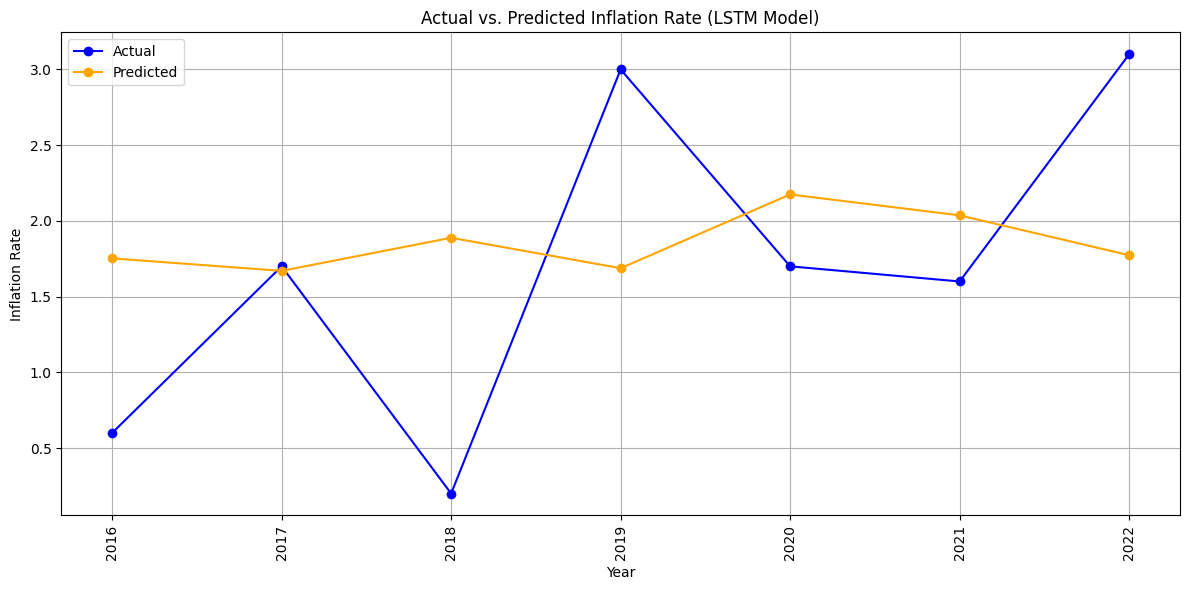

In [230]:
df_results = pd.DataFrame(
    {
        "Year": df2["Year "][-len(y_test_inv) :],
        "Actual": y_test_inv.flatten(),
        "Predicted": y_pred_inv.flatten(),
    }
)

# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(
    df_results["Year"],
    df_results["Actual"],
    marker="o",
    linestyle="-",
    color="blue",
    label="Actual",
)
plt.plot(
    df_results["Year"],
    df_results["Predicted"],
    marker="o",
    linestyle="-",
    color="orange",
    label="Predicted",
)

# Customize the plot
plt.title("Actual vs. Predicted Inflation Rate (LSTM Model)")
plt.xlabel("Year")
plt.ylabel("Inflation Rate")
plt.grid(True)
plt.legend()

# Rotating the x-axis labels for better readability
plt.xticks(rotation=90)

# Showing the plot
plt.tight_layout()
plt.show()

#### Future Inflation Prediction

In [231]:
# Use the last sequence from the dataset
last_sequence = X[-1]

# Reshape to match the model input shape
last_sequence = last_sequence.reshape(1, last_sequence.shape[0], 1)

# Predict the future values
number_of_future_steps = 5  # Adjust this according to your needs
future_values = []
for _ in range(number_of_future_steps):
    prediction = model.predict(last_sequence)
    future_values.append(prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = prediction[0, 0]

# Inverse transform the predicted values
future_values_inv = scaler.inverse_transform(np.array(future_values).reshape(-1, 1))

# Print the predicted future values
print("Predicted Future Values:")
print(future_values_inv)

1/1 [==============================] - 0s 32ms/step
Predicted Future Values:
[[1.674557 ]
 [1.6765403]
 [1.6833273]
 [1.6990346]
 [1.7145773]]


In [232]:
inflation_future_pred_list = np.insert(future_values_inv, 0, y_test_inv[-1])
inflation_future_pred_list

array([3.1      , 1.674557 , 1.6765403, 1.6833273, 1.6990346, 1.7145773],
      dtype=float32)

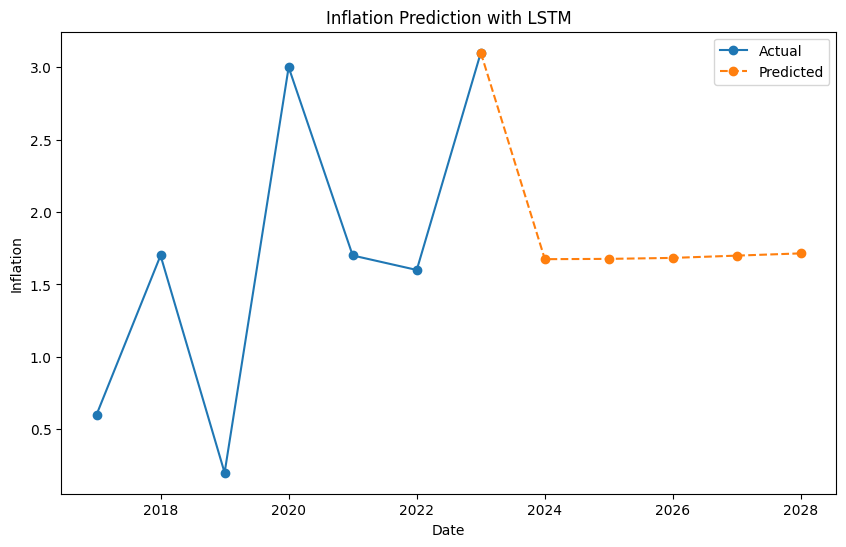

In [233]:
# Plotting
plt.figure(figsize=(10, 6))

# If not, convert 'Year' to datetime index before proceeding
idf.index = pd.to_datetime(idf.index, format='%Y')
# Generate existing years
existing_years = pd.date_range(start=idf.index[-len(y_test_inv)] + pd.DateOffset(years=1), periods=len(y_test_inv), freq='Y').year

# Plot the original data
plt.plot(existing_years, y_test_inv, label="Actual", marker='o')

# Plot the predicted values on the existing plot
# Generate additional years
future_years = pd.date_range(start=idf.index[-1] + pd.DateOffset(years=1), periods=6, freq='Y').year
plt.plot(future_years, inflation_future_pred_list, '--', label="Predicted", marker='o')

plt.title("Inflation Prediction with LSTM")
plt.xlabel("Date")
plt.ylabel("Inflation")
plt.legend()
plt.show()

#### Generate Predicted Output in Excel Sheet

In [241]:
predicted_inflation_recession_yearly = pd.DataFrame({'Year':future_years, 'Inflation':inflation_future_pred_list, 'Recession':recession_future_pred_list})
predicted_inflation_recession_yearly['Month'] = '-12-31'
predicted_inflation_recession_yearly['Year'] = predicted_inflation_recession_yearly['Year'].astype('str')+predicted_inflation_recession_yearly['Month'].astype('str')
predicted_inflation_recession_yearly.drop('Month', axis=1, inplace=True)
# Historic data
predicted_inflation_recession_yearly[['Inflation', 'Recession']] = predicted_inflation_recession_yearly[['Inflation', 'Recession']].round(2)
predicted_inflation_recession_yearly.to_excel('../output_data/Inflation_Recession_Yearly.xlsx', index=False)
print(predicted_inflation_recession_yearly.head())


         Year  Inflation    Recession
0  2023-12-31       3.10  1873.229980
1  2024-12-31       1.67  1885.349976
2  2025-12-31       1.68  1900.500000
3  2026-12-31       1.68  1908.579956
4  2027-12-31       1.70  1901.180054
